# Introduction

In this project, you will build a neural network of your own design to evaluate the MNIST dataset.

Some of the benchmark results on MNIST include can be found [on Yann LeCun's page](http://yann.lecun.com/exdb/mnist/) and include:

88% [Lecun et al., 1998](http://yann.lecun.com/exdb/publis/pdf/lecun-98.pdf)
95.3% [Lecun et al., 1998](http://yann.lecun.com/exdb/publis/pdf/lecun-98.pdf)
99.65% [Ciresan et al., 2011](http://people.idsia.ch/~juergen/ijcai2011.pdf)

MNIST is a great dataset for sanity checking your models, since the accuracy levels achieved by large convolutional neural networks and small linear models are both quite high. This makes it important to be familiar with the data.

## Imports

In [1]:
## This cell contains the essential imports you will need – DO NOT CHANGE THE CONTENTS! ##
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.backends.mps as mps
import torchvision
from torchvision import transforms
import matplotlib.pyplot as plt
import numpy as np

## Load the Dataset

Specify your transforms as a list if you intend to .
The transforms module is already loaded as `transforms`.

MNIST is fortunately included in the torchvision module.
Then, you can create your dataset using the `MNIST` object from `torchvision.datasets` ([the documentation is available here](https://pytorch.org/vision/stable/datasets.html#mnist)).
Make sure to specify `download=True`! 

Once your dataset is created, you'll also need to define a `DataLoader` from the `torch.utils.data` module for both the train and the test set.

In [2]:
# Define transforms
training_transforms = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,)), transforms.RandomRotation(10), transforms.RandomHorizontalFlip()])
test_transforms = transforms.Compose(
    [transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
view_transforms = transforms.Compose([transforms.ToTensor()])


# Create training set and define training dataloader
training_data = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=training_transforms)
training_loader = torch.utils.data.DataLoader(
    training_data, batch_size=64, shuffle=True)

training_data_nt = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=view_transforms)
training_loader_nt = torch.utils.data.DataLoader(
    training_data_nt, batch_size=64, shuffle=True)


# Create test set and define test dataloader
test_data = torchvision.datasets.MNIST(
    root='./data', train=False, download=True, transform=test_transforms)
test_loader = torch.utils.data.DataLoader(
    test_data, batch_size=64, shuffle=True)

## Justify your preprocessing

In your own words, why did you choose the transforms you chose? If you didn't use any preprocessing steps, why not?

**I made tansforms for both training data and test data. For the training data, I transformed to tensor, normalized it, and applied random rotation and random horizontal flip. For the test data, I transformed to tensor and normalized it. I chose these transforms because I wanted to make the training data more diverse and the test data to be as close to the training data as possible. I also normalized the data because it makes the training process faster and more accurate.**

## Explore the Dataset
Using matplotlib, numpy, and torch, explore the dimensions of your data.

You can view images using the `show5` function defined below – it takes a data loader as an argument.
Remember that normalized images will look really weird to you! You may want to try changing your transforms to view images.
Typically using no transforms other than `toTensor()` works well for viewing – but not as well for training your network.
If `show5` doesn't work, go back and check your code for creating your data loaders and your training/test sets.

In [3]:
## This cell contains a function for showing 5 images from a dataloader – DO NOT CHANGE THE CONTENTS! ##
def show5(img_loader):
    dataiter = iter(img_loader)

    batch = next(dataiter)
    labels = batch[1][0:5]
    images = batch[0][0:5]
    for i in range(5):
        print(int(labels[i].detach()))

        image = images[i].numpy()
        plt.imshow(image.T.squeeze().T)
        plt.show()

4


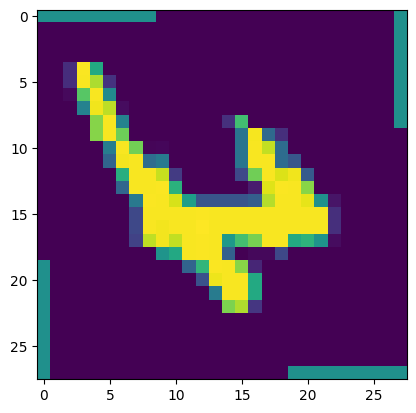

0


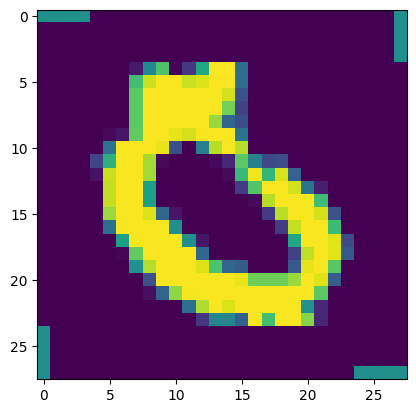

2


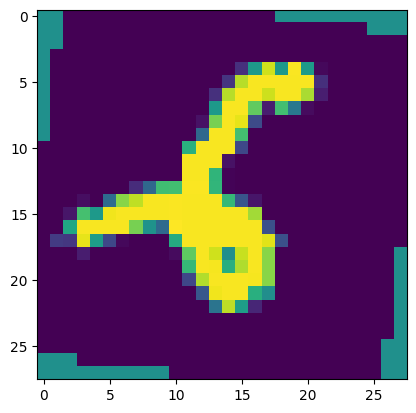

7


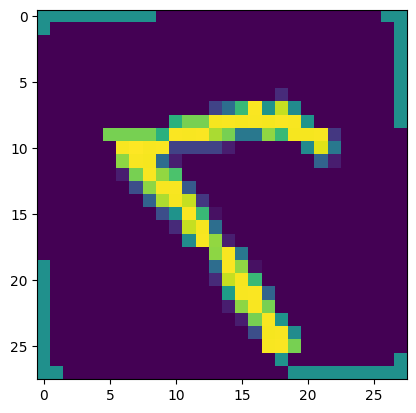

2


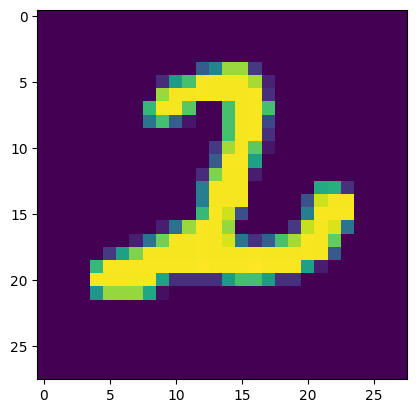

In [4]:
# Explore data
show5(training_loader)

### Using only transform to tensor

8


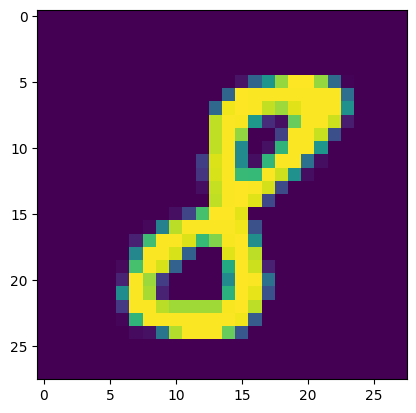

0


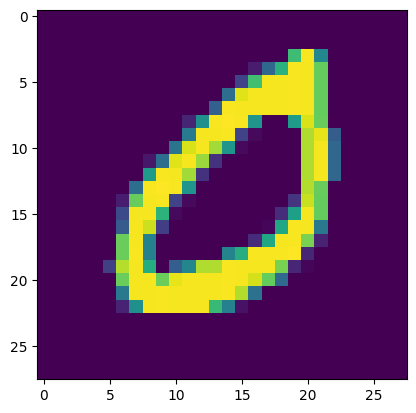

0


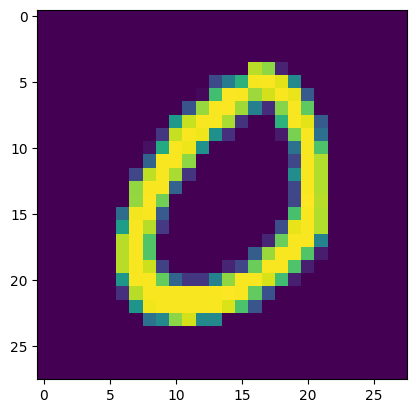

2


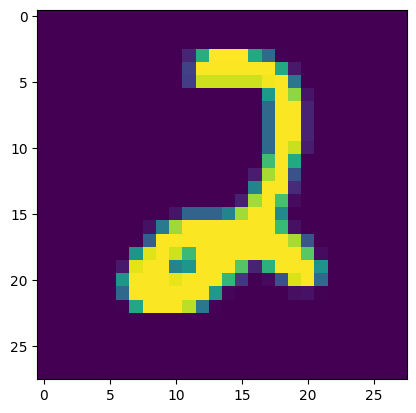

8


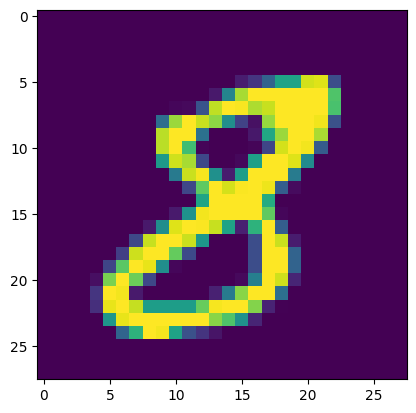

In [5]:
show5(training_loader_nt)

##### Using only transform to tensor for training data actually works well for viewing. Normalizing and adding other transforms is not so great for veiwing but is good for training.

### The images are 28x28 pixels, so the input layer will have 784 nodes. The output layer will have 10 nodes, one for each digit. 

## Build your Neural Network
Using the layers in `torch.nn` (which has been imported as `nn`) and the `torch.nn.functional` module (imported as `F`), construct a neural network based on the parameters of the dataset.
Use any architecture you like. 

*Note*: If you did not flatten your tensors in your transforms or as part of your preprocessing and you are using only `Linear` layers, make sure to use the `Flatten` layer in your network!

In [6]:
# Build your Neural Network
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.dropout = nn.Dropout(p=0.2)
        self.fc1 = nn.Linear(784, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64, 10)

    def forward(self, x):
        # make sure input tensor is flattened
        x = x.view(x.shape[0], -1)
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.dropout(F.relu(self.fc2(x)))
        x = self.dropout(F.relu(self.fc3(x)))
        x = F.log_softmax(self.fc4(x), dim=1)

        return x

Specify a loss function and an optimizer, and instantiate the model.

If you use a less common loss function, please note why you chose that loss function in a comment.

In [7]:
## YOUR CODE HERE ##
model = Net()
#loss function for classification
criterion = nn.NLLLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

# For other devices with CUDA support, pass cuda as the device argument to the model constructor.
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
model.to(device)
print(device)

cpu


## Running your Neural Network
Use whatever method you like to train your neural network, and ensure you record the average loss at each epoch. 
Don't forget to use `torch.device()` and the `.to()` method for both your model and your data if you are using GPU!

If you want to print your loss **during** each epoch, you can use the `enumerate` function and print the loss after a set number of batches. 250 batches works well for most people!

In [8]:
num_epochs = 15
steps = 0

train_losses, test_losses = [], []
for e in range(num_epochs):
    running_loss = 0
    for inputs, labels in training_loader:
        # Move input and label tensors to the available device
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        
    else:
        test_loss = 0
        accuracy = 0
        
        # Turn off gradients for validation, saves memory and computations
        with torch.no_grad():
            model.eval()
            for inputs, labels in test_loader:
                # Move input and label tensors to the available device
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                test_loss += criterion(outputs, labels)
                
                ps = torch.exp(outputs)
                top_p, top_class = ps.topk(1, dim=1)
                equals = top_class == labels.view(*top_class.shape)        
        model.train()
        
        train_losses.append(running_loss/len(training_loader))
        test_losses.append(test_loss/len(test_loader))
        print("Epoch: {}/{}.. ".format(e+1, num_epochs),
              "Training Loss: {:.3f}.. ".format(train_losses[-1]),
              "Test Loss: {:.3f}.. ".format(test_losses[-1]))
print("Trained on ", device)

Epoch: 1/15..  Training Loss: 0.873..  Test Loss: 0.431.. 
Epoch: 2/15..  Training Loss: 0.446..  Test Loss: 0.262.. 
Epoch: 3/15..  Training Loss: 0.347..  Test Loss: 0.196.. 
Epoch: 4/15..  Training Loss: 0.301..  Test Loss: 0.196.. 
Epoch: 5/15..  Training Loss: 0.268..  Test Loss: 0.164.. 
Epoch: 6/15..  Training Loss: 0.246..  Test Loss: 0.160.. 
Epoch: 7/15..  Training Loss: 0.230..  Test Loss: 0.155.. 
Epoch: 8/15..  Training Loss: 0.221..  Test Loss: 0.157.. 
Epoch: 9/15..  Training Loss: 0.210..  Test Loss: 0.135.. 
Epoch: 10/15..  Training Loss: 0.196..  Test Loss: 0.133.. 
Epoch: 11/15..  Training Loss: 0.190..  Test Loss: 0.129.. 
Epoch: 12/15..  Training Loss: 0.181..  Test Loss: 0.128.. 
Epoch: 13/15..  Training Loss: 0.176..  Test Loss: 0.114.. 
Epoch: 14/15..  Training Loss: 0.168..  Test Loss: 0.131.. 
Epoch: 15/15..  Training Loss: 0.168..  Test Loss: 0.112.. 
Trained on  cpu


Plot the training loss (and validation loss/accuracy, if recorded).

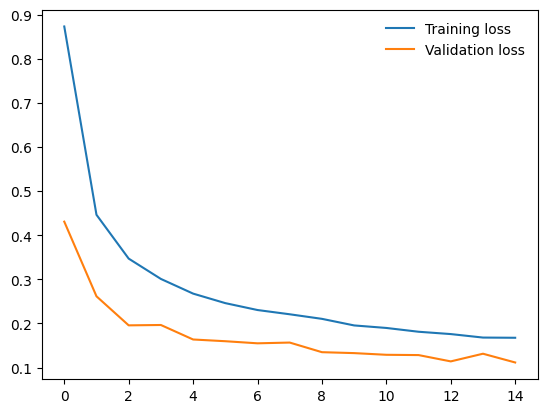

In [9]:
## YOUR CODE HERE ##
# Plot the training and validation loss
plt.plot(train_losses, label='Training loss')
plt.plot(test_losses, label='Validation loss')
plt.legend(frameon=False)
plt.show()

## Testing your model
Using the previously created `DataLoader` for the test set, compute the percentage of correct predictions using the highest probability prediction. 

If your accuracy is over 90%, great work, but see if you can push a bit further! 
If your accuracy is under 90%, you'll need to make improvements.
Go back and check your model architecture, loss function, and optimizer to make sure they're appropriate for an image classification task.

In [10]:
## YOUR CODE HERE ##
# Using the previously created `DataLoader` for the test set, compute the percentage of correct predictions using the highest probability prediction.
# Print the percentage as a float between 0 and 1.
model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
print('Accuracy of the network on the test images: %d %%' % (100 * correct / total))
        

Accuracy of the network on the test images: 96 %


## Improving your model

Once your model is done training, try tweaking your hyperparameters and training again below to improve your accuracy on the test set!

## Saving your model
Using `torch.save`, save your model for future loading.